In [501]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

PHI_MIN = np.deg2rad(-50.0)
PHI_MAX = np.deg2rad(50.0)

lengths = np.array([0.07, 0.07, 0.07, 0.096], dtype=np.float64)
# limits = np.array([
#     [np.deg2rad(-90.0), np.deg2rad(90.0)],
#     [np.deg2rad(-90.0), np.deg2rad(90.0)],
#     [np.deg2rad(-150.0), np.deg2rad(30.0)],
#     [np.deg2rad(-120.0), np.deg2rad(60.0)],
# ], dtype=np.float64)
limits = np.array([
    [np.deg2rad(-90.0), np.deg2rad(90.0)],
    [np.deg2rad(-90.0), np.deg2rad(90.0)],
    [np.deg2rad(-90.0), np.deg2rad(90.0)],
    [np.deg2rad(-90.0), np.deg2rad(90.0)],
], dtype=np.float64)


In [502]:
def angles_360_to_180(angles):

    for i in range(angles.shape[0]):
        if(angles[i] < -np.pi):
            angles[i] += np.pi*2.0
        elif(angles[i] > np.pi): 
            angles[i] -= np.pi*2.0

def ik(Q, phi, lengths, limits, angles_out):

    L0 = lengths[0]
    L1 = lengths[1]
    L2 = lengths[2]
    L3 = lengths[3]

    xy = np.sqrt(Q[0] * Q[0] + Q[1] * Q[1]) - L0 - L3 * np.sin(phi)
    z = Q[2] + L3 * np.cos(phi)

    v = (xy * xy + z * z - L1 * L1 - L2 * L2) / (2.0 * L1 * L2)

    if(v < -1.0 or v > 1.0):
        return False
    
    a2 = -np.arccos(v)
    a1 = np.arctan2(z, xy) - np.arctan2(L2 * np.sin(a2), L1 + L2 * np.cos(a2))

    a3 = phi - a1 - a2 - np.pi * 0.5
    a0 = np.arctan2(Q[1], Q[0])

    angles_out[0] = a0
    angles_out[1] = a1
    angles_out[2] = a2
    angles_out[3] = a3

    angles_360_to_180(angles_out)
    
    for i in range(angles_out.shape[0]):
        if(angles_out[i] < limits[i][0] or angles_out[i] > limits[i][1]):
            return False
        
    return True


Q = np.array([0.15, 0.0, 0.0], np.float64)
phi = np.deg2rad(0.0)
angles = np.zeros(4, dtype=np.float64)
result = ik(Q, phi, lengths, limits, angles)
print(f"angles: {np.rad2deg(angles)}, result={result}")


angles: [   0.           76.99263142  -53.59640503 -113.39622639], result=False


In [621]:
def loss(
        phi_target, 
        phi_actual, 
        phi_weight=1.0, 
        angles_old=None, 
        angles_new=None,
        angles_weight=0.5
    ):

    loss = 0.0

    if(phi_target is not None):
        phi_delta = phi_target - phi_actual
        loss += (np.square(phi_delta) + np.abs(phi_delta)) * phi_weight

    if(angles_old is not None):
        angles_delta = angles_old-angles_new
        loss += np.amax(np.square(angles_delta) + np.abs(angles_delta)) * angles_weight
        # loss += np.amax(np.square(angles_delta)) * angles_weight
        # loss += np.amax(np.abs(angles_delta)) * angles_weight

    return loss

def search(Q, phi_target, lengths, limits, angles_out):

    reductions_max = 8
    stepsize = max(
        (PHI_MAX - phi_target), (phi_target - PHI_MIN)
    )

    phi_z = phi_target
    
    angles_z = np.zeros(4, dtype=np.float64)
    angles_a = np.zeros(4, dtype=np.float64)
    angles_b = np.zeros(4, dtype=np.float64)

    has_result = False
    phi_result = np.nan

    for i in range(reductions_max):


        phi_a = phi_z - stepsize
        phi_b = phi_z + stepsize

        if(phi_a < PHI_MIN):
            phi_a = PHI_MIN

        if(phi_b > PHI_MAX):
            phi_b = PHI_MAX
            
        print(np.rad2deg(phi_a), np.rad2deg(phi_z), np.rad2deg(phi_b))

        result_z = ik(Q, phi_z, lengths, limits, angles_z)
        result_a = ik(Q, phi_a, lengths, limits, angles_a)
        result_b = ik(Q, phi_b, lengths, limits, angles_b)

        loss_z = loss(phi_target, phi_z) if result_z else np.inf
        loss_a = loss(phi_target, phi_a) if result_a else np.inf
        loss_b = loss(phi_target, phi_b) if result_b else np.inf

        print(loss_a, loss_z, loss_b)

        if(result_a is True and loss_a < loss_z):
            np.copyto(angles_out, angles_a)
            phi_z = phi_a
            has_result = True
        elif(result_b is True and loss_b < loss_z):
            np.copyto(angles_out, angles_b)
            phi_z = phi_b
            has_result = True
        elif(result_z is True): 
            np.copyto(angles_out, angles_z)
            has_result = True

        stepsize *= 0.5

    return has_result, phi_z if has_result else np.nan

def search_dumb(Q, phi_target, lengths, limits, angles_out, angles_old=None, num_phi_vals=101):

    phi_vals = np.linspace(PHI_MIN, PHI_MAX, num_phi_vals)
    best_loss = np.inf
    best_loss_idx = -1
    angles_ik = np.zeros(4, dtype=np.float64)

    for idx, phi in enumerate(phi_vals):

        result = ik(Q, phi, lengths, limits, angles_ik)

        if(result):
            loss_val = loss(phi_target=phi_target, phi_actual=phi, angles_old=angles_old, angles_new=angles_ik)
            if(loss_val < best_loss):
                best_loss_idx = idx
                best_loss = loss_val
                np.copyto(angles_out, angles_ik)

    has_result = best_loss_idx != -1
    best_phi = phi_vals[best_loss_idx] if has_result else np.nan

    return has_result, best_phi



def search_dumb2(Q, phi_target, lengths, limits, angles_out):

    phi_vals = np.linspace(PHI_MIN, PHI_MAX, 101)
    best_loss = np.inf
    best_loss_idx = -1
    angles_ik = np.zeros(4, dtype=np.float64)

    phi_step = np.deg2rad(1.0)

    result = ik(Q, phi_target, lengths, limits, angles_ik)

    has_result = False
    best_phi = np.nan

    if(result):
        has_result = True
        best_phi = phi_target
    else:

        scan_left = True
        scan_right = True

        phi_left = phi_target
        phi_right = phi_target

        while(scan_left or scan_right):
            
            if(scan_left):
                phi_left -= phi_step
                if(phi_left < PHI_MIN):
                    scan_left = False
                else: 
                    result_left = ik(Q, phi_left, lengths, limits, angles_ik)
                    if(result_left):
                        has_result = True
                        best_phi = phi_left
                        break

            if(scan_right):
                phi_right += phi_step
                if(phi_left > PHI_MAX):
                    scan_right = False
                else: 
                    result_right = ik(Q, phi_right, lengths, limits, angles_ik)
                    if(result_right):
                        best_phi = phi_right
                        break
        
    return has_result, best_phi



duration=7.31ms
True
[  0.          29.81559222 -64.40555925 -63.41003297]
-7.999999999999998


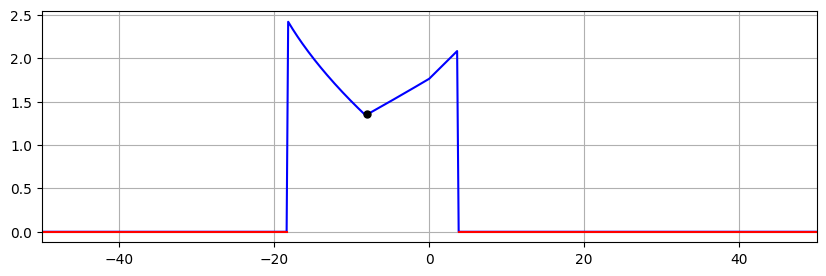

In [504]:
Q = np.array([0.175, 0.0, -0.1], np.float64)
phi_vals = np.linspace(PHI_MIN, PHI_MAX, 501)
loss_vals = []
valid_vals = []

phi_target = np.deg2rad(0.0)
angles_old = np.array(np.deg2rad([0.0, 0.0, 0.0, 0.0]), dtype=np.float64)

for phi in phi_vals:

    angles_ik = np.zeros(4, dtype=np.float64)
    result = ik(Q, phi, lengths, limits, angles_ik)

    valid_vals.append(result)
    
    if(result):
        loss_val = loss(phi_target=phi_target, phi_actual=phi, angles_old=angles_old, angles_new=angles_ik)
        loss_vals.append(loss_val)
    else:
        loss_vals.append(0.0)

valid_y = [np.nan if val is True else 0.0 for val in valid_vals]

angles_found = np.zeros(4, dtype=np.float64)

t_start = time.time()

has_result, phi_result = search_dumb(Q, phi_target, lengths, limits, angles_found, angles_old=angles_old, num_phi_vals=201)

t_end = time.time()
t_dur = t_end-t_start

print(f"duration={t_dur*1000:.2f}ms")

print(has_result)
print(np.rad2deg(angles_found))
print(np.rad2deg(phi_result))

matplotlib.rcParams['figure.figsize'] = [10,3]
fig, ax = plt.subplots()

ax.plot(np.rad2deg(phi_vals), loss_vals, color="blue")
ax.plot(np.rad2deg(phi_vals), valid_y, color="red")

ax.plot(np.rad2deg(phi_result), loss(phi_target, phi_result, angles_old=angles_old, angles_new=angles_found), marker="o", ms=5, color="black",)

ax.grid()
ax.set_xlim(np.rad2deg(PHI_MIN), np.rad2deg(PHI_MAX))

plt.show()

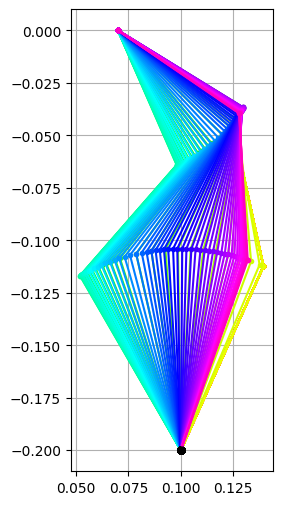

In [624]:
def fk_list(angles, lengths):

    pos_list = []

    pos_x = lengths[0]
    pos_y = 0

    pos_list.append([pos_x, pos_y])

    pos_x = pos_x + np.cos(angles[1]) * lengths[1]
    pos_y = pos_y + np.sin(angles[1]) * lengths[1]

    pos_list.append([pos_x, pos_y])
    
    pos_x = pos_x + np.cos(angles[1] + angles[2]) * lengths[2]
    pos_y = pos_y + np.sin(angles[1] + angles[2]) * lengths[2]
    
    pos_list.append([pos_x, pos_y])
    
    pos_x = pos_x + np.cos(angles[1] + angles[2] + angles[3]) * lengths[3]
    pos_y = pos_y + np.sin(angles[1] + angles[2] + angles[3]) * lengths[3]
    
    pos_list.append([pos_x, pos_y])

    return np.array(pos_list, dtype=np.float64)

pos_target_list = []
phi_target_list = []

n = 100
for i in range(n):
    x = 0.1
    y = 0.0
    z = -0.2
    t = float(i)/float(n)
    pos_target_list.append(np.array([x, y, z], dtype=np.float64))
    phi_target_list.append(np.deg2rad(-np.cos(t*2.0*np.pi)*30.0))

# n = 200
# angle_min = -np.pi*0.75
# angle_max = np.pi*0.1
# for i in range(n):
#     angle = (angle_max-angle_min)/n*i + angle_min
#     x = 0.15 + np.cos(angle) * 0.125
#     y = 0.0
#     z = -0.05 + np.sin(angle) * 0.15
#     pos_target_list.append(np.array([x, y, z], dtype=np.float64))
    
#     if(i < n//2):
#         phi_target_list.append(np.deg2rad(0.0))
#     else:
#         phi_target_list.append(None)
        
# n = 100
# angle_min = -np.pi*0.75
# angle_max = 0.0
# for i in range(n):
#     angle = (angle_max-angle_min)/n*i + angle_min
#     x = 0.125 + np.cos(angle) * 0.08
#     y = 0.0
#     z = -0.07 + np.sin(angle) * 0.02
#     pos_target_list.append(np.array([x, y, z], dtype=np.float64))
#     phi_target_list.append(np.deg2rad(0.0))

# n = 200
# angle_min = 0.0
# angle_max = np.pi*2.0*1.0
# for i in range(n):
#     angle = (angle_max-angle_min)/n*i + angle_min
#     x = 0.125 + np.cos(angle) * 0.05
#     y = 0.0
#     z = -0.07 + np.sin(angle) * 0.05
#     pos_target_list.append(np.array([x, y, z], dtype=np.float64))
#     phi_target_list.append(np.deg2rad(0.0))

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [6,6]
fig, ax = plt.subplots()
colormap = matplotlib.colormaps['gist_rainbow']
colors = colormap(np.linspace(0.0, 1.0, len(pos_target_list)))

angles_result = None

angles_old = np.zeros(4, dtype=np.float64)
# angles_old = None

for i in range(len(pos_target_list)):

    pos_target = pos_target_list[i]
    phi_target = phi_target_list[i]
    
    t_start = time.time()

    angles_result = np.zeros(4, dtype=np.float64)
    
    has_result, result_phi = search_dumb(pos_target, phi_target, lengths, limits, angles_result, angles_old=angles_old, num_phi_vals=501)

    # print(pos_target, np.rad2deg(phi_target))

    if(not has_result):

        print(f"i={i}, search failed")
        angles_old = None
        ax.plot(pos_target[0], pos_target[2], color="black", ms=5, marker="x")

    else: 

        # print(f"i={i}, phi={np.rad2deg(result_phi)}")
    
        pos_list = fk_list(angles_result, lengths)
        pos_list = np.array(pos_list)

        # if(angles_old is not None):
        #     angles_delta_max = np.amax(angles_old - angles_result)
        #     print(f"angles_delta_max={np.rad2deg(angles_delta_max):.2f}deg")

        angles_old = angles_result.copy()
        
        color = colors[i]

        ax.plot(pos_list[:,0], pos_list[:,1], color=color, ms=3, marker="o")
        ax.plot(pos_target[0], pos_target[2], color="black", ms=5, marker="o")

ax.set_aspect("equal")
ax.grid()

plt.show()


[ 0.15  0.   -0.15  1.  ]
[ 0.08648862 -0.06792631 -0.15        1.        ]
[ 0.15181677 -0.0408665  -0.15        1.        ]
[ 0.17887657 -0.10619465 -0.15        1.        ]
[ 0.11354842 -0.13325446 -0.15        1.        ]


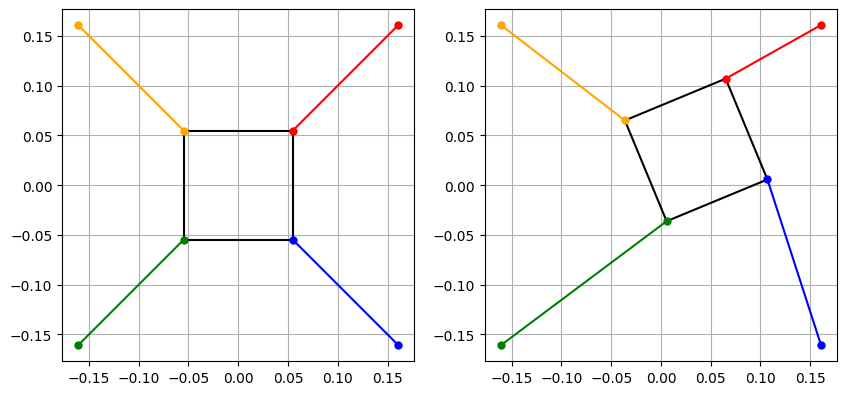

In [506]:
def matrix_trans(out, x, y, z):
    out[:,:] = 0.0
    out[0,0] = 1.0
    out[1,1] = 1.0
    out[2,2] = 1.0
    out[3,3] = 1.0
    out[0,3] = x
    out[1,3] = y
    out[2,3] = z

def matrix_rotz(out, angle):
    out[:,:] = 0.0
    out[0,0] = +np.cos(angle)
    out[0,1] = -np.sin(angle)
    out[1,0] = +np.sin(angle)
    out[1,1] = +np.cos(angle)
    out[2,2] = 1.0
    out[3,3] = 1.0

diagonal = 0.155*0.5
dx = diagonal / np.sqrt(2)
dy = diagonal / np.sqrt(2)

R0 = np.zeros((4,4), dtype=np.float64)
R1 = np.zeros((4,4), dtype=np.float64)
R2 = np.zeros((4,4), dtype=np.float64)
R3 = np.zeros((4,4), dtype=np.float64)
matrix_rotz(R0, np.deg2rad(45.0))
matrix_rotz(R1, np.deg2rad(135.0))
matrix_rotz(R2, np.deg2rad(-135.0))
matrix_rotz(R3, np.deg2rad(-45.0))
R0_inv = np.linalg.inv(R0)
R1_inv = np.linalg.inv(R1)
R2_inv = np.linalg.inv(R2)
R3_inv = np.linalg.inv(R3)

T0 = np.zeros((4,4), dtype=np.float64)
T1 = np.zeros((4,4), dtype=np.float64)
T2 = np.zeros((4,4), dtype=np.float64)
T3 = np.zeros((4,4), dtype=np.float64)
matrix_trans(T0, dx, dy, 0)
matrix_trans(T1, -dx, dy, 0)
matrix_trans(T2, -dx, -dy, 0)
matrix_trans(T3, dx, -dy, 0)
T0_inv = np.linalg.inv(T0)
T1_inv = np.linalg.inv(T1)
T2_inv = np.linalg.inv(T2)
T3_inv = np.linalg.inv(T3)

hip_angle = np.deg2rad(0.0)
fd = 0.15
fh = -0.15
f0 = np.array([fd*np.cos(hip_angle), fd*np.sin(hip_angle), fh, 1.0], dtype=np.float64)
f1 = np.array([fd*np.cos(-hip_angle), fd*np.sin(-hip_angle), fh, 1.0], dtype=np.float64)
f2 = np.array([fd*np.cos(hip_angle), fd*np.sin(hip_angle), fh, 1.0], dtype=np.float64)
f3 = np.array([fd*np.cos(-hip_angle), fd*np.sin(-hip_angle), fh, 1.0], dtype=np.float64)

h0 = T0@R0@np.array([0,0,0,1], dtype=np.float64)
h1 = T1@R1@np.array([0,0,0,1], dtype=np.float64)
h2 = T2@R2@np.array([0,0,0,1], dtype=np.float64)
h3 = T3@R3@np.array([0,0,0,1], dtype=np.float64)

v0 = T0@R0@f0
v1 = T1@R1@f1
v2 = T2@R2@f2
v3 = T3@R3@f3

matplotlib.rcParams['figure.figsize'] = [10,5]
fig, axs = plt.subplots(ncols=2)

ax = axs[0]
ax.plot([h0[0], h1[0], h2[0], h3[0], h0[0]], [h0[1], h1[1], h2[1], h3[1], h0[1]], color="black")
ax.plot([h0[0], v0[0]], [h0[1], v0[1]], color="red", ms=5, marker="o")
ax.plot([h1[0], v1[0]], [h1[1], v1[1]], color="orange", ms=5, marker="o")
ax.plot([h2[0], v2[0]], [h2[1], v2[1]], color="green", ms=5, marker="o")
ax.plot([h3[0], v3[0]], [h3[1], v3[1]], color="blue", ms=5, marker="o")
ax.grid()
ax.set_aspect("equal")

v_shift = np.array([0.05/np.sqrt(2), 0.05/np.sqrt(2), 0, 1], dtype=np.float64)
# v_shift = np.array([0, 0, 0, 1], dtype=np.float64)
M_shift = np.zeros((4,4), dtype=np.float64)
matrix_trans(M_shift, v_shift[0], v_shift[1], v_shift[2])
M_shift_inv = np.linalg.inv(M_shift)

M_rotz = np.zeros((4,4), dtype=np.float64)
matrix_rotz(M_rotz, np.deg2rad(22.5))
M_rotz_inv = np.linalg.inv(M_rotz)

ht0 = M_shift@M_rotz@h0
ht1 = M_shift@M_rotz@h1
ht2 = M_shift@M_rotz@h2
ht3 = M_shift@M_rotz@h3

ft0 = R0_inv@T0_inv@M_rotz_inv@M_shift_inv@v0
ft1 = R1_inv@T1_inv@M_rotz_inv@M_shift_inv@v1
ft2 = R2_inv@T2_inv@M_rotz_inv@M_shift_inv@v2
ft3 = R3_inv@T3_inv@M_rotz_inv@M_shift_inv@v3

print(f0)
print(ft0)
print(ft1)
print(ft2)
print(ft3)

ax = axs[1]
ax.plot([ht0[0], ht1[0], ht2[0], ht3[0], ht0[0]], [ht0[1], ht1[1], ht2[1], ht3[1], ht0[1]], color="black")
ax.plot([ht0[0], v0[0]], [ht0[1], v0[1]], color="red", ms=5, marker="o")
ax.plot([ht1[0], v1[0]], [ht1[1], v1[1]], color="orange", ms=5, marker="o")
ax.plot([ht2[0], v2[0]], [ht2[1], v2[1]], color="green", ms=5, marker="o")
ax.plot([ht3[0], v3[0]], [ht3[1], v3[1]], color="blue", ms=5, marker="o")
ax.grid()
ax.set_aspect("equal")

plt.show()


(150, 4, 4)


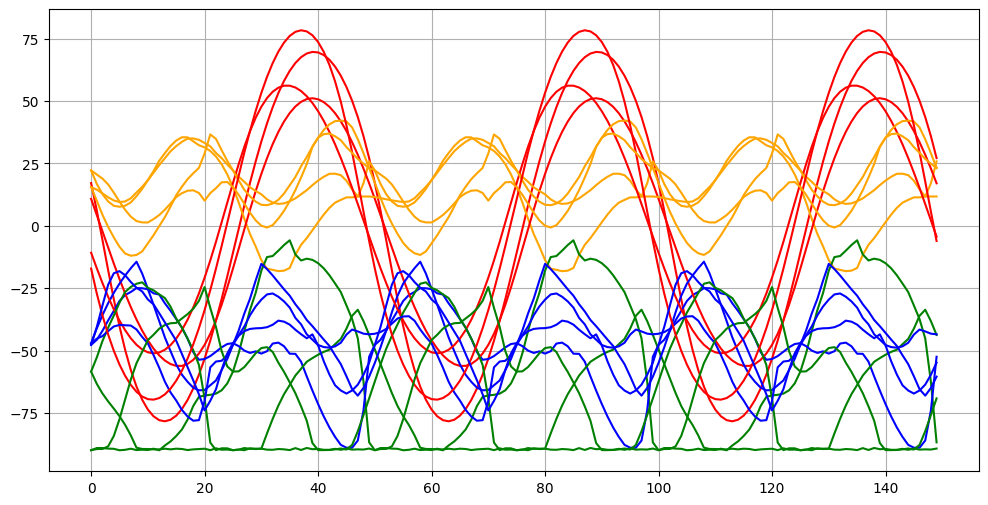

In [666]:
def surf(fr, x, y, z, rotz):
    
    v_shift = np.array([x, y, z, 1], dtype=np.float64)
    # v_shift = np.array([0, 0, 0, 1], dtype=np.float64)
    M_shift = np.zeros((4,4), dtype=np.float64)
    matrix_trans(M_shift, v_shift[0], v_shift[1], v_shift[2])
    M_shift_inv = np.linalg.inv(M_shift)

    M_rotz = np.zeros((4,4), dtype=np.float64)
    matrix_rotz(M_rotz, rotz)
    M_rotz_inv = np.linalg.inv(M_rotz)

    v0 = T0@R0@fr[0]
    v1 = T1@R1@fr[1]
    v2 = T2@R2@fr[2]
    v3 = T3@R3@fr[3]

    ft0 = R0_inv@T0_inv@M_rotz_inv@M_shift_inv@v0
    ft1 = R1_inv@T1_inv@M_rotz_inv@M_shift_inv@v1
    ft2 = R2_inv@T2_inv@M_rotz_inv@M_shift_inv@v2
    ft3 = R3_inv@T3_inv@M_rotz_inv@M_shift_inv@v3

    return [ft0, ft1, ft2, ft3]

hip_angle = np.deg2rad(0.0)
fd = 0.15
fh = -0.125

fr0 = np.array([fd*np.cos(hip_angle), fd*np.sin(hip_angle), fh, 1.0], dtype=np.float64)
fr1 = np.array([fd*np.cos(-hip_angle), fd*np.sin(-hip_angle), fh, 1.0], dtype=np.float64)
fr2 = np.array([fd*np.cos(hip_angle), fd*np.sin(hip_angle), fh, 1.0], dtype=np.float64)
fr3 = np.array([fd*np.cos(-hip_angle), fd*np.sin(-hip_angle), fh, 1.0], dtype=np.float64)
fr = [fr0, fr1, fr2, fr3]

n = 150
angle_min = 0.0
angle_max = np.pi*2.0*3
angles_list = []

for i in range(n):

    # print(f"i={i}")

    angle = (angle_max-angle_min)/n*i + angle_min
    t = i/50

    x = np.cos(angle) * 0.05
    y = np.sin(angle) * 0.05
    z = np.sin(t*2.0*np.pi*2.0) * 0.025
    rotz = np.deg2rad(np.sin(t*np.pi*2.0)*45.0)
    
    ft = surf(fr, x, y, z, rotz)

    angles = []
    phi_target = np.deg2rad(0.0)

    for j in range(len(ft)):
        angles_out = np.zeros(4, dtype=np.float64)
        angles_old = angles_list[i-1][j] if i > 0 else None

        has_result, phi_result = search_dumb(ft[j], phi_target, lengths, limits, angles_out, angles_old, num_phi_vals=201)
        angles.append(angles_out)

        if(not has_result):
            print(f"j={j}, has_result={has_result}")

    angles_list.append(angles)

angles_list = np.array(angles_list, dtype=np.float64)

print(angles_list.shape)


matplotlib.rcParams['figure.figsize'] = [12,6]
fig, ax = plt.subplots()
for i_leg in range(4):
    ax.plot(np.rad2deg(angles_list[:,i_leg,0]), color="red")
    ax.plot(np.rad2deg(angles_list[:,i_leg,1]), color="orange")
    ax.plot(np.rad2deg(angles_list[:,i_leg,2]), color="green")
    ax.plot(np.rad2deg(angles_list[:,i_leg,3]), color="blue")
ax.grid()
plt.show()
    

(150, 4, 4)


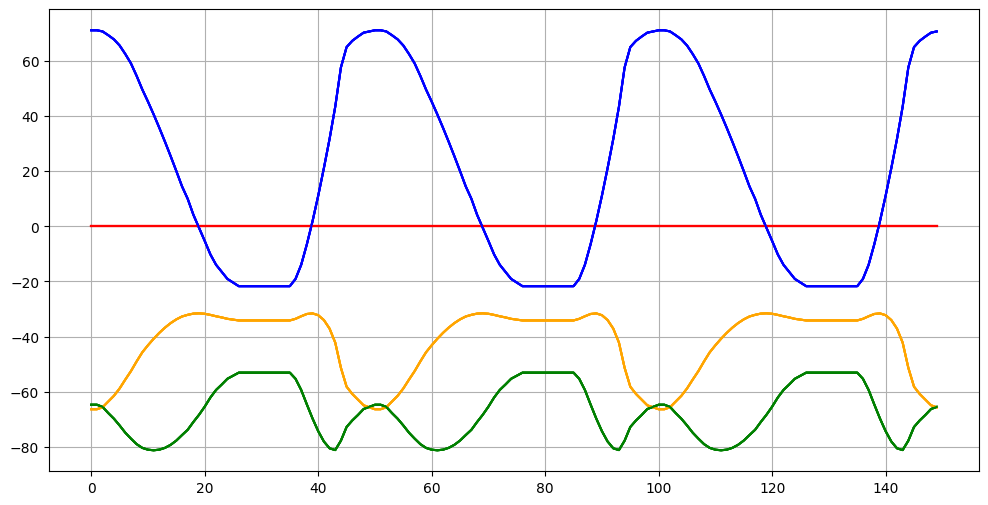

In [664]:
hip_angle = np.deg2rad(0.0)
fd = 0.1
fh = -0.2

fr0 = np.array([fd*np.cos(hip_angle), fd*np.sin(hip_angle), fh, 1.0], dtype=np.float64)
fr1 = np.array([fd*np.cos(-hip_angle), fd*np.sin(-hip_angle), fh, 1.0], dtype=np.float64)
fr2 = np.array([fd*np.cos(hip_angle), fd*np.sin(hip_angle), fh, 1.0], dtype=np.float64)
fr3 = np.array([fd*np.cos(-hip_angle), fd*np.sin(-hip_angle), fh, 1.0], dtype=np.float64)
fr = [fr0, fr1, fr2, fr3]

n = 150
angles_list = []

for i in range(n):

    t = i/50

    x = 0.0
    y = 0.0
    z = 0.0
    rotz = np.deg2rad(0.0)
    
    ft = surf(fr, x, y, z, rotz)

    angles = []
    phi_target = np.deg2rad(np.cos(2.0*np.pi*t) * 30.0)

    for j in range(len(ft)):
        angles_out = np.zeros(4, dtype=np.float64)
        angles_old = angles_list[i-1][j] if i > 0 else None

        has_result, phi_result = search_dumb(ft[j], phi_target, lengths, limits, angles_out, angles_old, num_phi_vals=201)
        angles.append(angles_out)

        if(not has_result):
            print(f"j={j}, has_result={has_result}")

    angles_list.append(angles)

angles_list = np.array(angles_list, dtype=np.float64)

print(angles_list.shape)

matplotlib.rcParams['figure.figsize'] = [12,6]
fig, ax = plt.subplots()
for i_leg in range(4):
    ax.plot(np.rad2deg(angles_list[:,i_leg,0]), color="red")
    ax.plot(np.rad2deg(angles_list[:,i_leg,1]), color="orange")
    ax.plot(np.rad2deg(angles_list[:,i_leg,2]), color="green")
    ax.plot(np.rad2deg(angles_list[:,i_leg,3]), color="blue")
ax.grid()
plt.show()
    

In [667]:
with open('angles_surfer2.txt', 'w') as f:

    angles_mat = angles_list.reshape(angles_list.shape[0], 16).T

    for i in range(angles_mat.shape[0]):
        line = "{"
        n = 0
        for j in range(100, angles_mat.shape[1]):
            line += f"{angles_mat[i,j]:.6f},"
            n += 1
        line += "},\n"
        f.write(line)

    print(f"n={n}")

n=50
